# Волатильность и корреляция фондовых индексов на множественных горизонтах

### Импорт необходимых библиотек

In [82]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import typing as tp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from arch import arch_model
from sklearn.metrics import mean_squared_error

### Зададим параметры генератора случайных чисел для воспроизводимости

In [83]:
np.random.seed(42)

### 1. Функции загрузки данных и предобработки

In [84]:
def download_price_data(tickers, start='2018-01-01', end=None, interval='1d'):
    """
    Загружает данные через yfinance. Возвращает DataFrame с колонками MultiIndex (Adj Close).
    """
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    data = yf.download(tickers, start=start, end=end, interval=interval, progress=False, threads=True)
    if isinstance(tickers, str) or len(tickers) == 1:
        data = pd.DataFrame(data)
    if ('Adj Close' in data.columns):
        prices = data['Adj Close']
    else:
        prices = data['Close']
    prices = prices.dropna(how='all')
    return prices

def compute_log_returns(prices):
    """
    Возвращает DataFrame лог-доходностей (pct_change -> log(1 + r))
    """
    return np.log(prices / prices.shift(1)).dropna(how='all')

### 2. Агрегация доходностей на разные горизонты
Будем считать горизонты:
- *daily* - исходные ежедневные доходности,
- *weekly* - доходности за неделю,
- *monthly* - доходности за месяц.

In [85]:
def aggregate_returns(log_returns, horizon='weekly'):
    """
    Возвращает агрегированные лог-доходности.
    """
    if horizon == 'daily':
        return log_returns
    if horizon == 'weekly':
        return log_returns.resample('W-FRI').sum().dropna(how='all')
    if horizon == 'monthly':
        return log_returns.resample('M').sum().dropna(how='all')
    raise ValueError("horizon must be 'daily'|'weekly'|'monthly'")

### 3. Реализованная волатильность
Реализованную волатильность будем оценивать следующим способом:
- rolling window realized: скользящая волатильность доходностей на окне `window` (в днях);

In [86]:
def realized_volatility(returns, window=21):
    """
    Скользящее стандартное отклонение по окну `window` (число периодов).
    returns: DataFrame с волатильностями.
    """
    rv = returns.rolling(window=window).std()
    return rv

### 4. Обучение GARCH(1,1) и предсказание условной волатильности
Используем модель GARCH(1,1).  
Будем обучать на дневных лог-доходностях каждого тикера отдельно и получать условную дисперсию (volatility = sqrt(cond_var)).  
Для горизонтов >1 дня - можно:
- масштабировать предсказанную ежедневную волатильность через `sqrt(h)` (приближённо), или
- агрегировать доходности на нужном горизонте и обучить GARCH заново (**целевой вариант**).


In [87]:
def fit_garch_and_predict(returns_series, index: tp.List, test_size: int = 100, p=1, q=1):
    """
    Возвращает DataFrame с колонками:
      - 'cond_vol' : условная волатильность на той же частоте (std)
    Если reindex_to задан (index), то результат будет переиндексован с forward-fill.
    """
    vols = []
    var = []
    for i in range(test_size):
      r = returns_series.dropna() # Удаляем NaN
      train = r[:-(test_size-i)]
      am = arch_model(train, vol='Garch', p=p, q=q)
      model_fit = am.fit(disp='off')
      pred = model_fit.forecast(horizon=1)
      cond_var = pred.variance.values[-1,:][0]
      cond_vol = np.sqrt(cond_var)
      vols.append(cond_vol)
      var.append(cond_var)
    out = pd.DataFrame({'cond_vol': vols, 'cond_var': var},
                       index=index)
    return model_fit, out

### 5. Корреляции на разных горизонтах
Корреляцию считаем по агрегированным доходностям (daily/weekly/monthly) - это простая корреляционная матрица.

In [88]:
def horizon_correlations(log_returns, horizons=['daily','weekly','monthly']):
    """
    Возвращает словарь horizon -> correlation matrix (DataFrame).
    """
    res = {}
    for h in horizons:
        agg = aggregate_returns(log_returns, horizon=h)
        corr = agg.corr()
        res[h] = corr
    return res

### 6. Применение описанного подхода на конкретных тикерах

In [89]:
# Параметры
tickers = ['SPY', 'AMZN', 'GOOG'] 
start_date = '2018-01-01'
end_date = '2025-10-12'

prices = download_price_data(tickers, start=start_date, end=end_date)
prices = prices.dropna(how='all')
prices.tail()

Ticker,AMZN,GOOG,SPY
Date,,,
2025-10-06,220.899994,251.509995,671.609985
2025-10-07,221.779999,247.130005,669.119995
2025-10-08,225.220001,245.460007,673.109985
2025-10-09,227.740005,242.210007,671.159973
2025-10-10,216.369995,237.490005,653.020020


In [90]:
# Вычисление лог-доходностей (daily)
logret = compute_log_returns(prices)
logret = logret.dropna(how='all')
logret = aggregate_returns(logret, horizon='daily')
logret.head()

Ticker,AMZN,GOOG,SPY
Date,,,
2018-01-03,0.012694,0.016280,0.006305
2018-01-04,0.004466,0.003615,0.004206
2018-01-05,0.016033,0.014466,0.006642
2018-01-08,0.014322,0.004264,0.001827
2018-01-09,0.004665,-0.000614,0.002261


In [91]:
logret.shape

(1954, 3)

In [92]:
# Реализованная волатильность
rv_daily = realized_volatility(logret, window=2)

In [93]:
rv_daily

Ticker,AMZN,GOOG,SPY
Date,,,
2018-01-03,NaN,NaN,NaN
2018-01-04,0.005818,0.008956,0.001484
2018-01-05,0.008179,0.007673,0.001722
2018-01-08,0.001210,0.007214,0.003404
2018-01-09,0.006828,0.003450,0.000307
...,...,...,...
2025-10-06,0.013744,0.014314,0.002542
2025-10-07,0.001652,0.026794,0.005158
2025-10-08,0.008072,0.007628,0.006830


In [94]:
test_size = int(0.3 * len(rv_daily))

In [95]:
test_size

586

In [97]:
# Обучаем GARCH(1,1) для каждого тикера на дневных лог-доходностях и предсказываем условную волатильность
garch_vols = pd.DataFrame(index=logret.index[-test_size:])
for col in logret.columns:
    res, out = fit_garch_and_predict(logret[col], test_size=test_size, p=1, q=1, index=logret.index[-test_size:])
    garch_vols[col] = out['cond_vol']

/home/eugene/miniconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/eugene/miniconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [98]:
garch_vols = garch_vols.sort_index()
garch_vols.head()

,AMZN,GOOG,SPY
Date,,,
2023-06-12,0.021338,0.017933,0.006798
2023-06-13,0.021678,0.017698,0.007236
2023-06-14,0.020575,0.017349,0.007105
2023-06-15,0.019557,0.017046,0.006550
2023-06-16,0.018668,0.016260,0.007870


In [99]:
# Сравнение predicted vs realized для одного тикера - пример для AMZN
ticker_example = 'AMZN'
df_cmp = pd.DataFrame({
    'realized_rv': rv_daily[ticker_example][-test_size:],
    'garch_vol': garch_vols[ticker_example]
}).dropna()

# Считаем RMSE между realized (скользящая std) и predicted (garch)
rmse_garch = np.sqrt(mean_squared_error(df_cmp['realized_rv'], df_cmp['garch_vol']))
print(f'RMSE (GARCH vs realized) для {ticker_example} в случае дневной агрегации: {rmse_garch:.4f}')

RMSE (GARCH vs realized) для AMZN в случае дневной агрегации: 0.0130


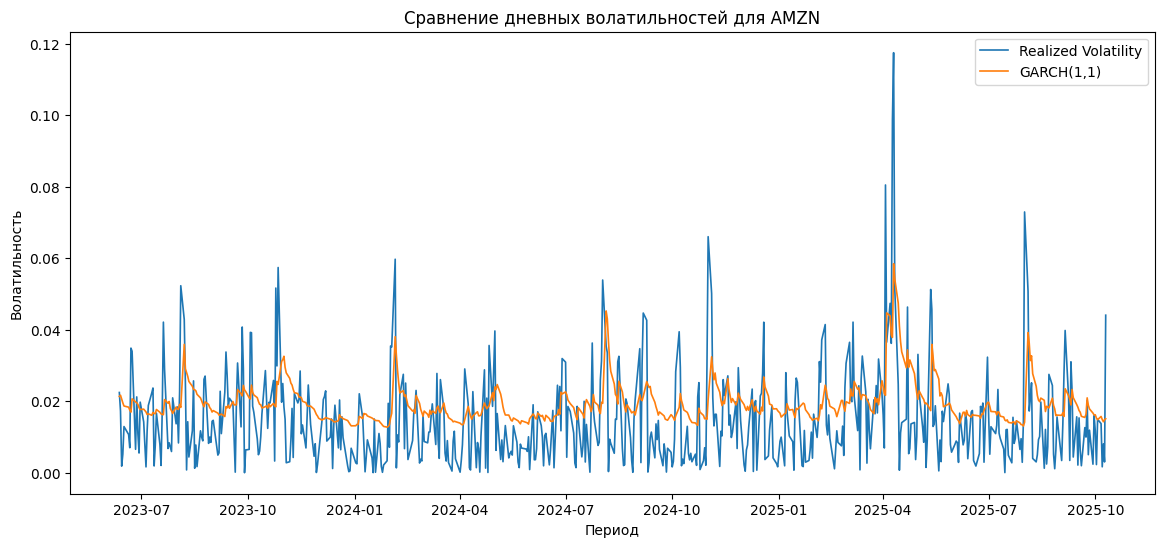

In [100]:
plt.figure(figsize=(14,6))
plt.plot(df_cmp.index, df_cmp['realized_rv'], label='Realized Volatility', linewidth=1.2)
plt.plot(df_cmp.index, df_cmp['garch_vol'], label='GARCH(1,1)', linewidth=1.2)
plt.title(f'Сравнение дневных волатильностей для {ticker_example}')
plt.ylabel('Волатильность')
plt.xlabel('Период')
plt.legend()
plt.show()

**Проделаем ту же работу и построим графики сравнения недельной и месячной волатильностей**

In [101]:
logret_week = aggregate_returns(logret, horizon='weekly')
logret_month = aggregate_returns(logret, horizon='monthly')

In [102]:
rv_week = realized_volatility(logret_week, window=2)  # недельное скользящее окно
rv_month = realized_volatility(logret_month, window=2) # месячное скользящее окно

In [103]:
test_size_week = int(0.3 * len(rv_week))

In [104]:
test_size_month = int(0.3 * len(rv_month))

In [105]:
# Для сравнения: обучим GARCH заново на агрегированных недельных доходностях (пример для одного тикера)
res_week, out_week = fit_garch_and_predict(logret_week[ticker_example], test_size=test_size_week, index=rv_week.index[-test_size_week:])
res_month, out_month = fit_garch_and_predict(logret_month[ticker_example], test_size=test_size_month, index=rv_month.index[-test_size_month:])

In [106]:
rmse_garch = np.sqrt(mean_squared_error(rv_week[ticker_example][-test_size_week:], out_week['cond_vol']))
print(f'RMSE (GARCH vs realized) для {ticker_example} в случае недельной агрегации: {rmse_garch:.4f}')

RMSE (GARCH vs realized) для AMZN в случае недельной агрегации: 0.0252


In [107]:
rmse_garch = np.sqrt(mean_squared_error(rv_week[ticker_example][-test_size_month:], out_month['cond_vol']))
print(f'RMSE (GARCH vs realized) для {ticker_example} в случае месячной агрегации: {rmse_garch:.4f}')

RMSE (GARCH vs realized) для AMZN в случае месячной агрегации: 0.0585


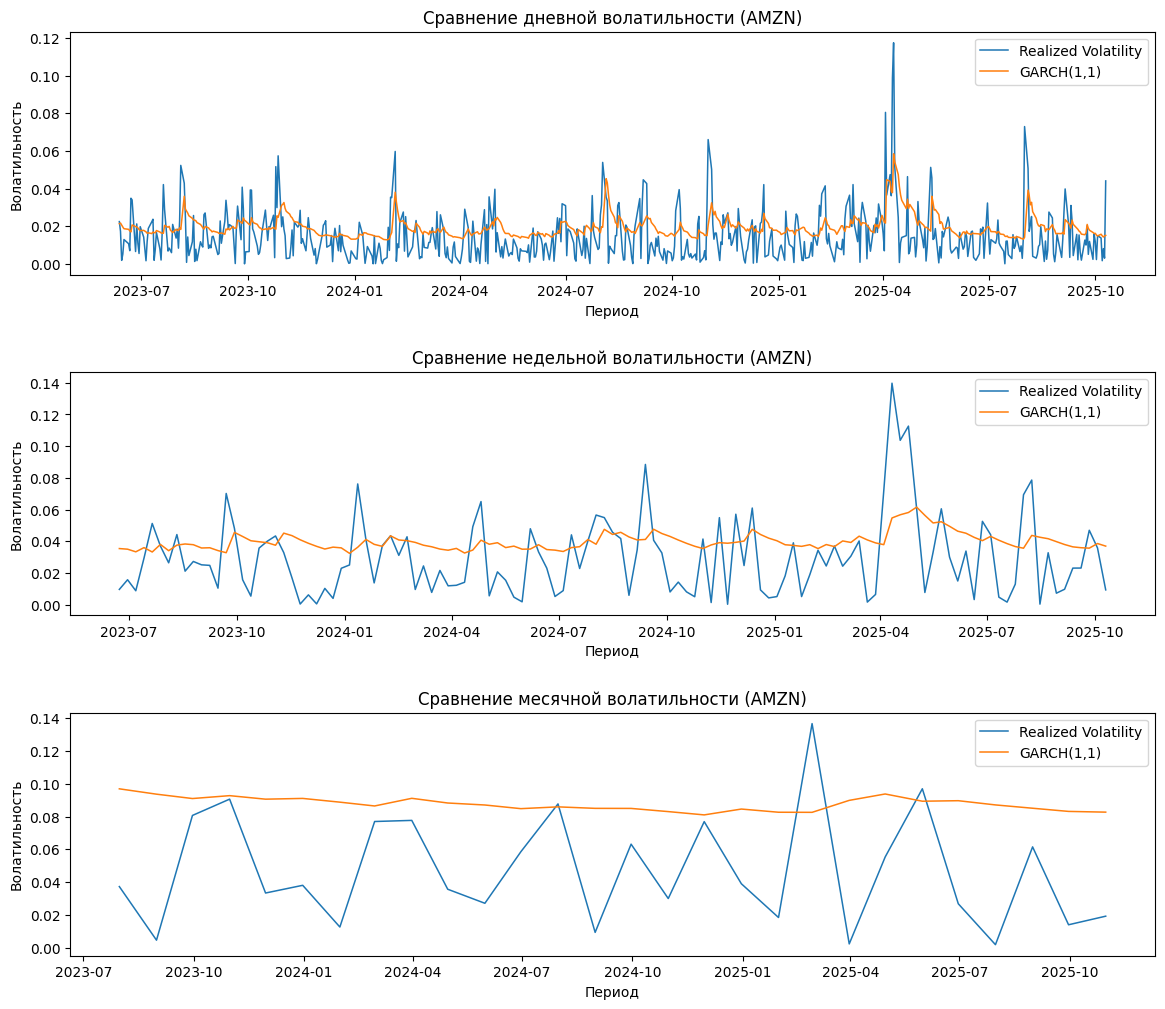

In [108]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharey=False)
plt.subplots_adjust(hspace=0.4)

axes[0].plot(rv_daily.index[-test_size:], rv_daily[ticker_example][-test_size:], label='Realized Volatility', linewidth=1.1)
axes[0].plot(garch_vols.index, garch_vols[ticker_example], label='GARCH(1,1)', linewidth=1.1)
axes[0].set_title(f'Сравнение дневной волатильности ({ticker_example})')
axes[0].set_ylabel('Волатильность')
axes[0].set_xlabel('Период')
axes[0].legend()

axes[1].plot(rv_week.index[-test_size_week:], rv_week[ticker_example][-test_size_week:], label='Realized Volatility', linewidth=1.1)
axes[1].plot(out_week.index, out_week['cond_vol'], label='GARCH(1,1)', linewidth=1.1)
axes[1].set_title(f'Сравнение недельной волатильности ({ticker_example})')
axes[1].set_ylabel('Волатильность')
axes[1].set_xlabel('Период')
axes[1].legend()

axes[2].plot(rv_month.index[-test_size_month:], rv_month[ticker_example][-test_size_month:], label='Realized Volatility', linewidth=1.1)
axes[2].plot(out_month.index, out_month['cond_vol'], label='GARCH(1,1)', linewidth=1.1)
axes[2].set_title(f'Сравнение месячной волатильности ({ticker_example})')
axes[2].set_ylabel('Волатильность')
axes[2].set_xlabel('Период')
axes[2].legend()

plt.show()

### 7. Корреляции между индексами на множественных горизонтах
Посчитаем матрицы корреляции доходностей для различных горизонтов и визуализируем.

In [ ]:
horizons_map = {
    'daily': 'день',
    'weekly': 'неделя',
    'monthly': 'месяц'
}

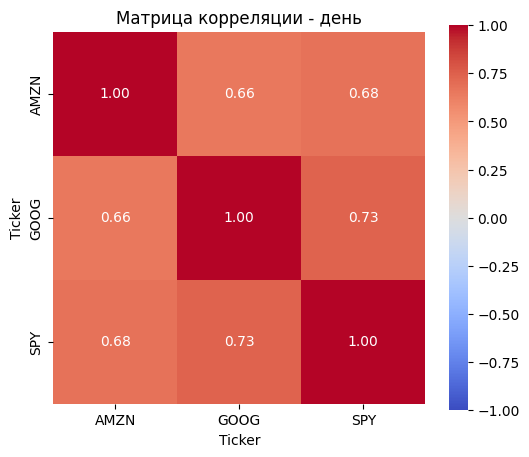

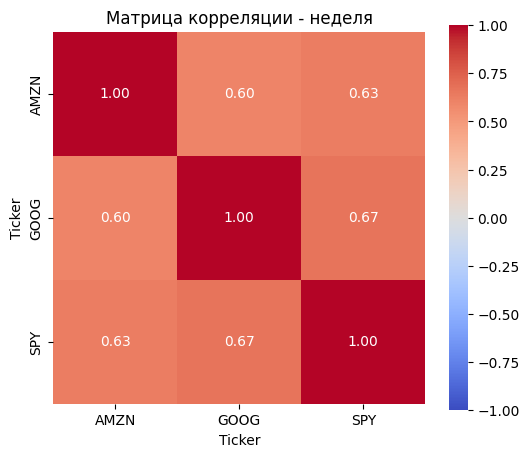

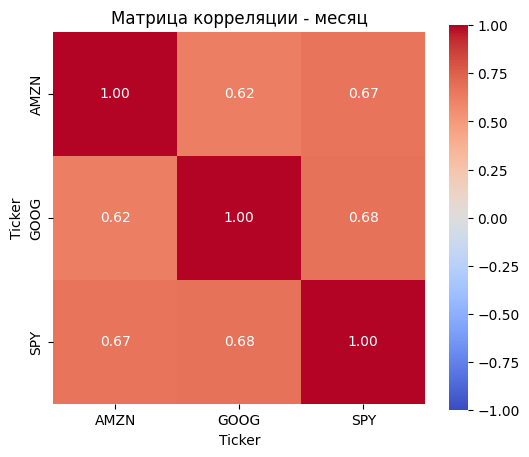

In [ ]:
corrs = horizon_correlations(logret, horizons=['daily','weekly','monthly'])

def plot_corr_matrix(corr_df, title=''):
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', square=True)
    plt.title(title)
    plt.show()

for h, mat in corrs.items():
    plot_corr_matrix(mat, title=f'Матрица корреляции - {horizons_map[h]}')

### 8. Выводы
- Реализованная волатильность, рассчитанная скользящим окном, позволяет оценить фактический уровень рыночных изменений;


- При переходе от дневного к недельному и месячному горизонтам наблюдается снижение амплитуды и частоты колебаний волатильности.  
  Это связано с эффектом усреднения: на более крупных временных интервалах краткосрочные колебания доходностей частично компенсируются, и оценка волатильности становится более сглаженной. Таким образом, характер поведения волатильности меняется - от "шумного" к более устойчивому;


- Волатильность фондовых индексов существенно изменяется во времени, что хорошо описывается моделью GARCH(1,1). Использование GARCH-модели в нашем случае позволяет получить оценку ожидаемой волатильности для каждого горизонта,  что открывает возможность построения многоуровневых стратегий управления риском, где решения принимаются с учётом разного временного масштаба;


- Можно отметить, что корреляция индексов SPY, GOOG, AMZN сначала падает при переходе от дневного к месячному горизонту, а затем растет, что противоречит устоявшимся наблюдениям, когда при переходе к бОльшим горизонтам корреляция должна непрерывно увеличиваться. Это можно объяснить асинхронной реакцией рынка на те или иные новости о той или иной компании в течение недели или месяца.